#### Imports

In [40]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_recall_curve
from sklearn.utils import shuffle
from PIL import Image

## Methods for Experiments

In [9]:
def get_distr(targets, labels):
    vals = {}
    for label in labels.keys():
        vals[label] = 0
    
    for target in targets:
        vals[target] += 1
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    langs = labels.values()
    students = vals.values()
    ax.bar(langs,students)
    plt.show()

In [55]:
def plot_ROC(y_test, y_pred, title):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_val = auc(fpr, tpr)
    plt.plot(fpr,tpr) 
    plt.plot([0, 1], [0, 1], linestyle='dashed')
    plt.axis([-0.05, 1.05, -0.05, 1.05])
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    title += "\nAUC: " + str(round(auc_val, 4))
    plt.title(title)
    plt.show()

In [13]:
def plot_cm(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt="d")
    plt.imshow(cm)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)

In [61]:
def plot_pr(y_test, y_pred, title):
    new_pred = []
    for val in y_pred:
        if val >= 0.5:
            new_pred.append(val)
        else:
            new_pred.append(0)
    prec, recall, _ = precision_recall_curve(y_test, new_pred)
    plt.plot(recall, prec)
    plt.ylim([0, 1])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title + " Precision vs Recall")

In [21]:
def convert_pred(y_pred, threshold):
    new_pred = np.empty((y_pred.size), dtype='int32')
    for i in range(y_pred.size):
        if y_pred[i] >= threshold:
            new_pred[i] = 1
        else:
            new_pred[i] = 0
    
    return new_pred

# Part 0: Load in csv data and format it to images and target data

Read in csv of metadata for the images and select target data. For our target data we are selecting COVID/Non-COVID, Survival, Intubation, and Admission to the ICU - resulting in 28 classes where class 0 = Non-COVID and class > 0 is COVID and some unique combination of the classes above. For the initial training and testing of this data, any class > 0 we set to 1 to train a binary classifier for COVID/Non-COVID

In [3]:
data = []
with open("metadata.csv") as file:
    for row in csv.reader(file):
        data.append(row)

data = data[1:]

d = {'filename': [], 'target': []}

for image in data:
    # skip volume data
    if image[22] == "volumes":
        continue
    
    # ignore CT scan data
    if image[19] == "CT":
        continue
    
    diagnosis = image[4].split("/")
    diagnosis = diagnosis[len(diagnosis) - 1].lower()
    # set target based on meta data
    if diagnosis != "covid-19":
        if diagnosis == "todo":
            # if not classified yet target = -1
            # d['filename'].append(image[23])
            # d['target'].append(-1)
            # ignore unknown data
            continue
        else:
            # if not COVID-19 target = 0
            d['filename'].append(image[23])
            d['target'].append(0)
    else:
        # if it is COVID-19
        if image[6] == "Y":
            # if they survived
            if image[7] == "Y":
                # if they were intubated
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(1)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(2)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(3)
            elif image[7] == "N":
                # if they were not intubated
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(4)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(5)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(6)
            else:
                # if they were intubated is unknown
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(7)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(8)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(9)
        elif image[6] == "N":
            # if they did not survive
            if image[7] == "Y":
                # if they were intubated
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(10)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(11)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(12)
            elif image[7] == "N":
                # if they were not intubated
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(13)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(14)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(15)
            else:
                # if they were intubated is unknown
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(16)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(17)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(18)
        else:
            # if their survival is unknown
            if image[7] == "Y":
                # if they were intubated
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(19)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(20)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(21)
            elif image[7] == "N":
                # if they were not intubated
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(22)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(23)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(23)
            else:
                # if they were intubated is unknown
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(24)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(25)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(26)

                    
# add normal chest xrays to data
dir_path = os.path.abspath(os.getcwd())
dir_path = dir_path+"/chest_xray/test/Normal"
list = os.listdir(dir_path)
for pic in list:
    d['filename'].append(pic)
    d['target'].append(0)
total = [0] * 28

for target in d['target']:
    if target == -1:
        total[27] += 1
    else:
        total[target] += 1

# set up binary classification (covid vs non-covid)
# all targets > 0 are covid
for i in range(len(d['target'])):
    if d['target'][i] > 0:
        d['target'][i] = 1

print(total)
#print(d)

file.close()


[513, 4, 3, 0, 0, 48, 0, 3, 6, 79, 8, 8, 2, 0, 1, 1, 0, 0, 18, 45, 31, 8, 0, 9, 0, 5, 225, 0]


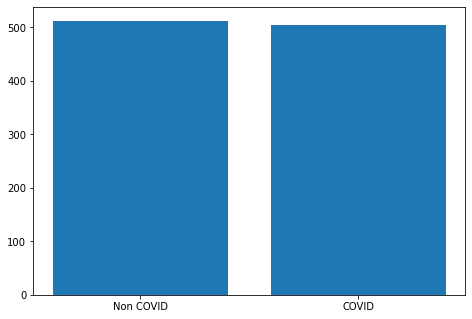

In [10]:
labels = {0: "Non COVID", 1: "COVID"}
get_distr(d['target'], labels)

In [4]:
print(len(d['target']))
print(d['target'].count(1))
print(d['target'].count(0))

1017
504
513


# Part 1: Preprocessing for images
Load in images for the corresponding target data with PIL. Reformat all images to the same dimensions and convert them to a numpy array for the models to use (where each is a (# pixels, # pixels) array).

In [5]:
# Load in image data from filenames with PIL
img_dim = 224
images = np.empty((len(d['target']), img_dim, img_dim, 2))

for i in range(len(d['filename'])):
    image = Image.open("model_images/" + d['filename'][i])
    
    # resize image shape
    image = image.resize((img_dim, img_dim))
    
    # convert to grayscale
    image = image.convert('LA')
    
    images[i] = np.array(image)

# normalize values
images = images / 255.0

# Part 2: Deep Learning Classifier with Keras

Split the data into training and testing with sklearn

In [6]:
# split data
x_train, x_test, y_train, y_test = train_test_split(images, d['target'], test_size=0.2, random_state=0)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

Build and compile the deep learning model

In [27]:
# build model
dl_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(img_dim,img_dim,2)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
dl_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

Train the model

In [28]:
history = dl_model.fit(x_train, y_train, epochs=10,
                   validation_data=(x_test, y_test))

Epoch 1/10
26/26 [==============================] - 5s 181ms/step - loss: 31.4315 - accuracy: 0.5080 - val_loss: 0.6160 - val_accuracy: 0.7108
Epoch 2/10
26/26 [==============================] - 4s 171ms/step - loss: 0.7685 - accuracy: 0.6617 - val_loss: 0.4846 - val_accuracy: 0.7941
Epoch 3/10
26/26 [==============================] - 5s 176ms/step - loss: 0.8160 - accuracy: 0.6359 - val_loss: 0.6219 - val_accuracy: 0.6765
Epoch 4/10
26/26 [==============================] - 4s 172ms/step - loss: 0.6991 - accuracy: 0.6974 - val_loss: 0.4688 - val_accuracy: 0.7696
Epoch 5/10
26/26 [==============================] - 4s 173ms/step - loss: 0.6180 - accuracy: 0.6937 - val_loss: 0.7498 - val_accuracy: 0.6176
Epoch 6/10
26/26 [==============================] - 5s 188ms/step - loss: 0.5465 - accuracy: 0.7306 - val_loss: 0.6341 - val_accuracy: 0.6814
Epoch 7/10
26/26 [==============================] - 5s 190ms/step - loss: 0.5972 - accuracy: 0.7232 - val_loss: 0.4916 - val_accuracy: 0.8137
Epoch

Evaluate the model with testing data

7/7 - 0s - loss: 0.5066 - accuracy: 0.7206
Test Accuracy: 0.7206


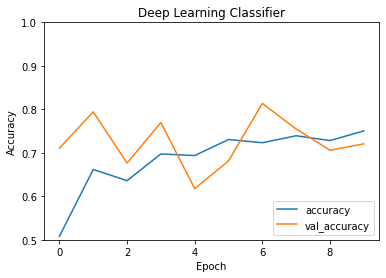

In [29]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Deep Learning Classifier')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = dl_model.evaluate(x_test, y_test, verbose=2)
print("Test Accuracy:", round(test_acc, 4))

In [30]:
dly_pred = dl_model.predict(x_test)

In [32]:
dly_pred_norm = convert_pred(dly_pred, 0.5)

In [34]:
print(classification_report(y_test, dly_pred_norm))

              precision    recall  f1-score   support

           0       0.68      0.85      0.76       104
           1       0.79      0.59      0.67       100

    accuracy                           0.72       204
   macro avg       0.73      0.72      0.71       204
weighted avg       0.73      0.72      0.72       204



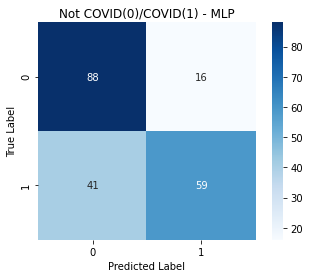

In [37]:
plot_cm(y_test, dly_pred_norm, "Not COVID(0)/COVID(1) - MLP")

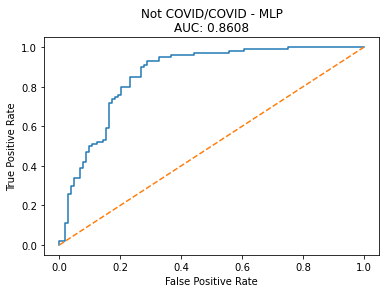

In [56]:
plot_ROC(y_test, dly_pred, "Not COVID/COVID - MLP")

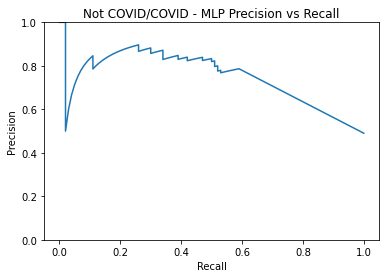

In [62]:

plot_pr(y_test, dly_pred, "Not COVID/COVID - MLP")

# Part 3: Classifier with a Convolution Neural Network

Build and compile the model

In [63]:
# build model for convolution network
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_dim, img_dim, 2)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# add more layers
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

# compile 
cnn_model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

In [64]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 173056)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

Train the model

In [65]:
history = cnn_model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_test, y_test))

Epoch 1/10
26/26 [==============================] - 33s 1s/step - loss: 1.2326 - accuracy: 0.5572 - val_loss: 0.6388 - val_accuracy: 0.6961
Epoch 2/10
26/26 [==============================] - 32s 1s/step - loss: 0.5834 - accuracy: 0.6950 - val_loss: 0.5193 - val_accuracy: 0.7647
Epoch 3/10
26/26 [==============================] - 30s 1s/step - loss: 0.5368 - accuracy: 0.7417 - val_loss: 0.4976 - val_accuracy: 0.7745
Epoch 4/10
26/26 [==============================] - 19s 740ms/step - loss: 0.5208 - accuracy: 0.7355 - val_loss: 0.4803 - val_accuracy: 0.7598
Epoch 5/10
26/26 [==============================] - 20s 752ms/step - loss: 0.4956 - accuracy: 0.7761 - val_loss: 0.4545 - val_accuracy: 0.8088
Epoch 6/10
26/26 [==============================] - 22s 829ms/step - loss: 0.4636 - accuracy: 0.7798 - val_loss: 0.4024 - val_accuracy: 0.8284
Epoch 7/10
26/26 [==============================] - 19s 747ms/step - loss: 0.4655 - accuracy: 0.7884 - val_loss: 0.4209 - val_accuracy: 0.8137
Epoch 8/

Evaluate the model with testing data and plot results

7/7 - 1s - loss: 0.4397 - accuracy: 0.8235
Test Accuracy: 0.8235


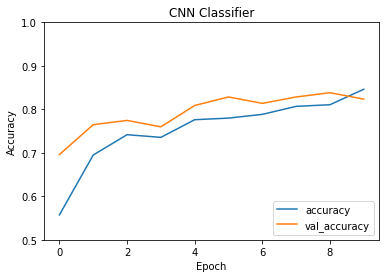

In [66]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Classifier')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = cnn_model.evaluate(x_test, y_test, verbose=2)
print("Test Accuracy:", round(test_acc, 4))

In [67]:
cnny_pred = cnn_model.predict(x_test)

In [68]:
cnny_pred_norm = convert_pred(cnny_pred, 0.5)

In [69]:
print(classification_report(y_test, cnny_pred_norm))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       104
           1       0.81      0.84      0.82       100

    accuracy                           0.82       204
   macro avg       0.82      0.82      0.82       204
weighted avg       0.82      0.82      0.82       204



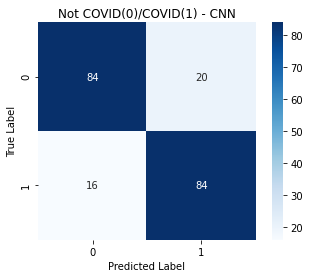

In [70]:
plot_cm(y_test, cnny_pred_norm, "Not COVID(0)/COVID(1) - CNN")

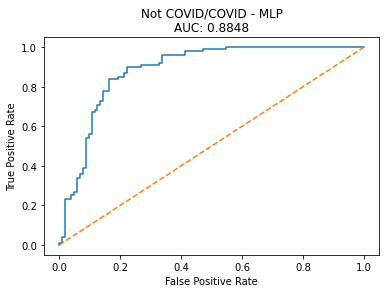

In [71]:
plot_ROC(y_test, cnny_pred, "Not COVID/COVID - MLP")

# Part 4: Optimization
Based on the results of the above models, we will now attempt to optimize our algorithms. We will be using cross validation to find a find the best split between our training/testing data.

In [431]:
# split data into 10 folds
folds = 10
kfold = KFold(n_splits=folds)

# shuffle initial data
rimages, rtargets = shuffle(images, d['target'], random_state=0)

Repeat Deep Learning and CNN models above with KFold technique and compare results

### Deep Learning - Cross Validation

In [432]:
results = []
test_accuracies = []

for train, test in kfold.split(rimages):
    x_train, x_test = rimages[train], rimages[test]
    y_train, y_test = np.array(rtargets)[train], np.array(rtargets)[test]
    
    # build model
    dl_model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(img_dim,img_dim,2)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(2)
    ])

    # compile model
    dl_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    # train model
    history = dl_model.fit(x_train, y_train, epochs=10,
                           validation_data=(x_test, y_test))
    
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    
    results.append(history)
    test_accuracies.append(test_acc)

Epoch 1/10
29/29 [==============================] - 1s 40ms/step - loss: 14.1133 - accuracy: 0.5158 - val_loss: 0.6477 - val_accuracy: 0.7647
Epoch 2/10
29/29 [==============================] - 1s 34ms/step - loss: 0.8426 - accuracy: 0.6710 - val_loss: 0.5029 - val_accuracy: 0.8039
Epoch 3/10
29/29 [==============================] - 1s 34ms/step - loss: 0.6776 - accuracy: 0.6743 - val_loss: 0.4829 - val_accuracy: 0.7353
Epoch 4/10
29/29 [==============================] - 1s 35ms/step - loss: 0.5471 - accuracy: 0.7333 - val_loss: 0.5030 - val_accuracy: 0.7941
Epoch 5/10
29/29 [==============================] - 1s 33ms/step - loss: 0.5572 - accuracy: 0.7257 - val_loss: 0.8368 - val_accuracy: 0.5686
Epoch 6/10
29/29 [==============================] - 1s 33ms/step - loss: 0.5975 - accuracy: 0.7224 - val_loss: 0.4859 - val_accuracy: 0.7549
Epoch 7/10
29/29 [==============================] - 1s 33ms/step - loss: 0.4797 - accuracy: 0.7694 - val_loss: 0.4960 - val_accuracy: 0.7843
Epoch 8/10
2

Get best model and plot results

In [434]:
# choose model with highest test accuracy
best_model = results[0]
best_acc = test_accuracies[0]
for i in range(len(results) - 1):
    if test_accuracies[i + 1] > test_accuracies[i]:
        best_model = results[i+1]

Test Accuracy: 0.7745


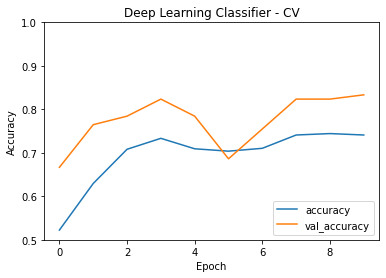

In [435]:
plt.plot(best_model.history['accuracy'], label='accuracy')
plt.plot(best_model.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Deep Learning Classifier - CV')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

print("Test Accuracy:", round(best_acc, 4))

### CNN - Cross Validation

In [436]:
results = []
test_accuracies = []

for train, test in kfold.split(rimages):
    x_train, x_test = rimages[train], rimages[test]
    y_train, y_test = np.array(rtargets)[train], np.array(rtargets)[test]
    
    # build model for convolusion network
    cnn_model = models.Sequential()
    cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_dim, img_dim, 2)))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # add more layers
    cnn_model.add(layers.Flatten())
    cnn_model.add(layers.Dense(64, activation='relu'))
    cnn_model.add(layers.Dense(2))

    # compile 
    cnn_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, epochs=10,
                            validation_data=(x_test, y_test))
    
    results.append(history)
    
    
    test_accuracies.append(test_acc)

Epoch 1/10
29/29 [==============================] - 6s 208ms/step - loss: 0.8524 - accuracy: 0.6120 - val_loss: 0.5194 - val_accuracy: 0.7647
Epoch 2/10
29/29 [==============================] - 6s 213ms/step - loss: 0.5608 - accuracy: 0.7224 - val_loss: 0.5182 - val_accuracy: 0.7647
Epoch 3/10
29/29 [==============================] - 6s 204ms/step - loss: 0.5321 - accuracy: 0.7246 - val_loss: 0.4708 - val_accuracy: 0.8039
Epoch 4/10
29/29 [==============================] - 6s 212ms/step - loss: 0.4977 - accuracy: 0.7639 - val_loss: 0.4644 - val_accuracy: 0.7549
Epoch 5/10
29/29 [==============================] - 6s 212ms/step - loss: 0.4879 - accuracy: 0.7607 - val_loss: 0.5008 - val_accuracy: 0.7255
Epoch 6/10
29/29 [==============================] - 7s 229ms/step - loss: 0.4719 - accuracy: 0.7650 - val_loss: 0.4467 - val_accuracy: 0.7941
Epoch 7/10
29/29 [==============================] - 7s 228ms/step - loss: 0.4679 - accuracy: 0.7683 - val_loss: 0.4919 - val_accuracy: 0.7451
Epoch 

Epoch 9/10
29/29 [==============================] - 7s 235ms/step - loss: 0.4175 - accuracy: 0.8011 - val_loss: 0.6221 - val_accuracy: 0.6961
Epoch 10/10
29/29 [==============================] - 7s 236ms/step - loss: 0.3917 - accuracy: 0.8131 - val_loss: 0.5930 - val_accuracy: 0.7647
Epoch 1/10
29/29 [==============================] - 8s 281ms/step - loss: 0.8861 - accuracy: 0.5956 - val_loss: 0.4631 - val_accuracy: 0.7745
Epoch 2/10
29/29 [==============================] - 6s 192ms/step - loss: 0.5505 - accuracy: 0.7333 - val_loss: 0.4296 - val_accuracy: 0.8137
Epoch 3/10
29/29 [==============================] - 6s 211ms/step - loss: 0.5209 - accuracy: 0.7497 - val_loss: 0.4380 - val_accuracy: 0.8039
Epoch 4/10
29/29 [==============================] - 6s 222ms/step - loss: 0.4758 - accuracy: 0.7716 - val_loss: 0.4253 - val_accuracy: 0.8431
Epoch 5/10
29/29 [==============================] - 6s 217ms/step - loss: 0.4641 - accuracy: 0.7607 - val_loss: 0.4158 - val_accuracy: 0.8235
Epoch

Get best model and plot results

In [437]:
# choose model with highest test accuracy
best_model = results[0]
best_acc = test_accuracies[0]
for i in range(len(results) - 1):
    if test_accuracies[i + 1] > test_accuracies[i]:
        best_model = results[i+1]

Test Accuracy: 0.8218


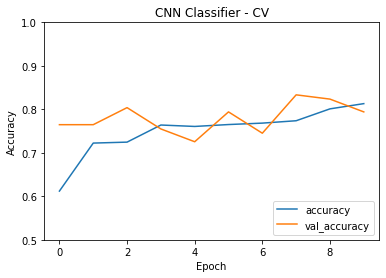

In [438]:
plt.plot(best_model.history['accuracy'], label='accuracy')
plt.plot(best_model.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("CNN Classifier - CV")
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

print("Test Accuracy:", round(best_acc, 4))